<a href="https://colab.research.google.com/github/DisableMan/Age-Images-Classification/blob/main/Age_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Cài đặt một số thư viện cần thiết
import glob
import pandas as pd 
import cv2,os
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt 
from skimage.feature import hog  
from sklearn.metrics import *
import cv2 as cv
from sklearn.decomposition import PCA 
from sklearn.svm import LinearSVC 
from numpy import linalg as LA

In [ ]:
# Đọc dữ liệu file từ Google drive
from google.colab import drive
drive.mount('/content/gdrive')
path_dataset = '/content/gdrive/My Drive/Age image classification/Dataset/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Nhãn
name_labels = ["20-45", "Dưới 20", "Trên 45"]

In [ ]:
# Đoạn code đọc dữ liệu theo folder từ google drive lưu dưới dạng danh sách (list)
data = []
labels_data = []
classes = 7

for index,path in enumerate(name_labels):
    path = path_dataset + path
    images = os.listdir(path)
    for a in images:
        # try:
            image = Image.open(path + '/'+ a)
            image = image.resize((224,224))
            image = np.array(image)
            data.append(image)
            labels_data.append(index)
        # except:
        #     print("Error loading image")
 
#Chuyển list thành mảng numpy
data = np.array(data)
labels_data = np.array(labels_data)

Nhãn  Trên 45 :


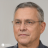

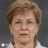

Nhãn  20-45 :


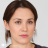

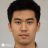

Nhãn  Dưới 20 :


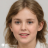

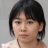

In [ ]:
# Hiển thị một số ảnh ví dụ trong bộ dữ liệu
from google.colab.patches import cv2_imshow
list_cls = os.listdir(path_dataset)
for cls in list_cls:
  list_img = os.listdir(path_dataset + str(cls))
  print("Nhãn ", cls,":")
  for i in list([0,10]):
    img_ = cv2.imread(path_dataset + str(cls) + '/' + list_img[i])
    img_ = cv2.resize(img_, (48,48), interpolation = cv2.INTER_AREA)
    cv2_imshow(img_)

In [ ]:
# Đoạn code thống kê số lượng trong dữ liệu.
classes = []
class_counter = 0

for dirname, _, filenames in os.walk(path_dataset):
    if dirname.endswith('/'):
        continue
    else:
        classes.append({dirname.split('/')[-1]: 0})
    file_count = 0
    for filename in filenames:
        file_count += 1
    classes[class_counter][dirname.split('/')[-1]] = file_count
    class_counter += 1
    
print('{:<45} {:<45}'.format('Nhãn', 'Số lượng mẫu'))
print()
for d in classes:
    [(k, v)] = d.items()
    print('{:<45} {:<45}'.format(k, v))

Nhãn                                          Số lượng mẫu                                 

Trên 45                                      100                                          
20-45                                         93                                           
Dưới 20                                    102                                          


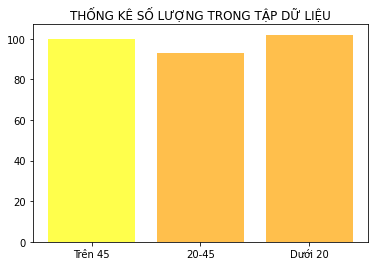

In [ ]:
# Đoạn code vẽ biểu đồ chart thống kê dữ liệu
counts = []
labels = []
for d in classes:
    [(k, v)] = d.items()
    labels.append(k)
    counts.append(v)

plt.figure()
plt.bar(range(len(counts)), counts, color = ['yellow', 'orange', 'orange', 'green', 'green', 'yellow'], alpha = .7)
plt.xticks(range(len(counts)), labels, rotation = 0)
plt.title('THỐNG KÊ SỐ LƯỢNG TRONG TẬP DỮ LIỆU')
plt.show()

In [ ]:
def images_to_hog(data): 
    features=[]
    for img in data:
        # img = cv.medianBlur(img,5)
        img = cv.cvtColor(img, cv2.COLOR_BGR2GRAY)
        crop_image = cv.adaptiveThreshold(img,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C,cv.THRESH_BINARY,11,2)
        descriptor = hog(crop_image, orientations=8,pixels_per_cell=(2,2), cells_per_block=(1, 1))
        features.append(descriptor)
    features=np.array(features)
    return features

In [ ]:
hog_features =images_to_hog(data)
print ('Training HOG output Features shape : ',hog_features.shape)
print ('Training HOG output Labels shape: ',labels_data.shape)

Training HOG output Features shape :  (295, 100352)
Training HOG output Labels shape:  (295,)


In [ ]:
# Để so sánh đánh giá chương trình, chúng ta sẽ chia thành 2 tập dữ liệu. 80% cho việc huấn luyện mô hình và 20% cho kiểm thử mô hình
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(hog_features, labels_data, test_size=0.2, random_state=42, stratify=labels_data)
print(len(X_train), len(y_train))
print(len(X_test), len(y_test))

236 236
59 59


In [ ]:
# Kết quả khi áp dụng đặc trưng HOG

classifier= LinearSVC(random_state=0, tol=1e-5,max_iter = 3000)
classifier.fit(X_train,y_train)

# Sau đó dự đoán trên tập test
y_pred = classifier.predict(X_test)

# Tính toán ác độ đo
precision = precision_score(y_test,y_pred, average="weighted")
recall = recall_score(y_test,y_pred, average="weighted")
f1 = f1_score(y_test,y_pred, average="weighted")

print("Độ chính xác:", precision)
print("Độ phủ:", recall)
print("Độ đo F1:", f1)
print(classification_report(y_test, y_pred))

Độ chính xác: 0.9014894709809964
Độ phủ: 0.8983050847457628
Độ đo F1: 0.8947443384133313
              precision    recall  f1-score   support

           0       0.93      0.74      0.82        19
           1       0.91      1.00      0.95        20
           2       0.86      0.95      0.90        20

    accuracy                           0.90        59
   macro avg       0.90      0.90      0.89        59
weighted avg       0.90      0.90      0.89        59



In [ ]:
# Áp dụng kỹ thuật PCA trên đặc trưng HOG cho tập train và tập test
pca = PCA(n_components = 100)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

print ('New Train Dataset shape after PCA: ',X_train_pca.shape)
print ('New Test Dataset shape after PCA: ',X_test_pca.shape)

New Train Dataset shape after PCA:  (236, 100)
New Test Dataset shape after PCA:  (59, 100)


In [ ]:
classifier= LinearSVC(random_state=0, tol=1e-5,max_iter = 3000)
classifier.fit(X_train_pca,y_train)

# Sau đó dự đoán trên tập test
y_pred_pca = classifier.predict(X_test_pca)

In [ ]:
precision = precision_score(y_test,y_pred_pca, average="weighted")
recall = recall_score(y_test,y_pred_pca, average="weighted")
f1 = f1_score(y_test,y_pred_pca, average="weighted")

print("Độ chính xác:", precision)
print("Độ phủ:", recall)
print("Độ đo F1:", f1)
print(classification_report(y_test, y_pred_pca))

Độ chính xác: 0.9326306793904001
Độ phủ: 0.9322033898305084
Độ đo F1: 0.9311469385880299
              precision    recall  f1-score   support

           0       0.94      0.84      0.89        19
           1       0.95      1.00      0.98        20
           2       0.90      0.95      0.93        20

    accuracy                           0.93        59
   macro avg       0.93      0.93      0.93        59
weighted avg       0.93      0.93      0.93        59



Saving duoi20.jpg to duoi20.jpg
ẢNH ĐẦU VÀO


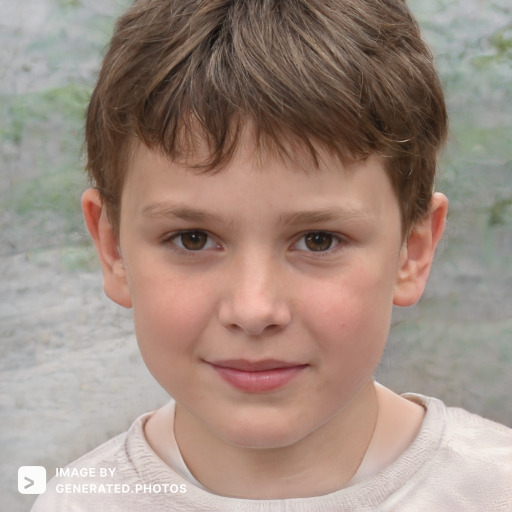

Kết quả mô hình dự đoán:  Dưới 20


In [ ]:
from google.colab import files

uploaded = files.upload()
name_file = ""
for fn in uploaded.keys():
  name_file = fn

image = Image.open(name_file)
image = image.resize((224,224))
image = np.array(image)
hog_input = images_to_hog([image])
hog_input_pca = pca.transform(hog_input)
output = classifier.predict(hog_input_pca)
# Hiển thị ảnh nhập vào
print("="*150)
print("ẢNH ĐẦU VÀO")
img_input = cv2.imread(name_file,1)
cv2_imshow(img_input)
print("="*150)
print("Kết quả mô hình dự đoán: ", name_labels[output[0]])